In [28]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

data = open('/content/drive/MyDrive/The Time Machine_half.txt').read()
corpus = data.lower().split("\n")
corpus[:10]

Mounted at /content/drive


['i',
 '',
 'the time traveller (for so it will be convenient to speak of him) was expounding a recondite matter to us.',
 '',
 'his grey eyes shone and twinkled, and his usually pale face was flushed and animated.',
 '',
 'the fire burned brightly, and the soft radiance of the incandescent lights in the lilies of silver caught the bubbles that flashed and passed in our glasses.',
 '',
 'our chairs, being his patents, embraced and caressed us rather than submitted to be sat upon, and there was that luxurious after-dinner atmosphere when thought roams gracefully free of the trammels of precision.',
 '']

In [29]:
import numpy as np
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical


# Создаем объект для токенизации
total_words = 1000
tokenizer = Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(corpus)

# tokenizer.index_word

In [30]:
print(corpus[0])
print(tokenizer.texts_to_sequences([corpus[0]]))
print(tokenizer.word_index['soft'], tokenizer.word_index['caressed'])

i
[[4]]
184 1250


In [31]:
# создадим последовательность токенов
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		sequence = token_list[:i+1]
		input_sequences.append(sequence)
input_sequences[:10]

[[1, 13],
 [1, 13, 47],
 [1, 13, 47, 19],
 [1, 13, 47, 19, 39],
 [1, 13, 47, 19, 39, 9],
 [1, 13, 47, 19, 39, 9, 81],
 [1, 13, 47, 19, 39, 9, 81, 40],
 [1, 13, 47, 19, 39, 9, 81, 40, 407],
 [1, 13, 47, 19, 39, 9, 81, 40, 407, 6],
 [1, 13, 47, 19, 39, 9, 81, 40, 407, 6, 326]]

In [32]:
# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
print(max_sequence_len)
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))
input_sequences[:10]

89


array([[  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   1,  13],
       [  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
          0,   0,   0,   0,   0,   0,   0,   0,   1,  13,  4

In [33]:
predictors, label = input_sequences[:,:-1], input_sequences[:,-1]

label = to_categorical(label, num_classes=total_words)
label.shape

(11464, 1000)

In [34]:
predictors[0], np.argmax(label[0])

(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1],
       dtype=int32), 13)

In [35]:
from keras.callbacks import EarlyStopping
from keras.layers import Dropout, Bidirectional
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from tensorflow.keras.optimizers import Adam


early_stop = EarlyStopping(monitor='val_loss', patience=10)

model = Sequential()
model.add(Embedding(input_dim=total_words,
                    output_dim=512,
                    input_length=max_sequence_len-1))

model.add(Bidirectional(LSTM(256, return_sequences=True)))
#model.add(Bidirectional(LSTM(512, return_sequences=True)))
model.add(LSTM(1024))
model.add(Dropout(0.2))
model.add(Dense(total_words * 2 , activation='relu'))
model.add(Dense(total_words, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer=Adam(0.001),
              metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 88, 512)           512000    
                                                                 
 bidirectional_3 (Bidirectio  (None, 88, 512)          1574912   
 nal)                                                            
                                                                 
 lstm_7 (LSTM)               (None, 1024)              6295552   
                                                                 
 dropout_3 (Dropout)         (None, 1024)              0         
                                                                 
 dense_6 (Dense)             (None, 2000)              2050000   
                                                                 
 dense_7 (Dense)             (None, 1000)              2001000   
                                                      

In [36]:
history = model.fit(predictors, label,
                    epochs=3,
                    validation_split=0.2,
                    callbacks=[early_stop],
                    verbose=1)

Epoch 1/3
287/287 [==============================] - 2512s 9s/step - loss: 5.7253 - accuracy: 0.0761 - val_loss: 5.5341 - val_accuracy: 0.0907
Epoch 2/3
287/287 [==============================] - 2550s 9s/step - loss: 5.4069 - accuracy: 0.0930 - val_loss: 5.4835 - val_accuracy: 0.0920
Epoch 3/3
287/287 [==============================] - 2510s 9s/step - loss: 5.1224 - accuracy: 0.1135 - val_loss: 5.4186 - val_accuracy: 0.1099


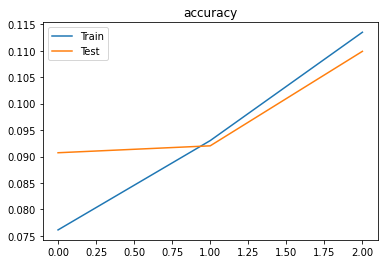

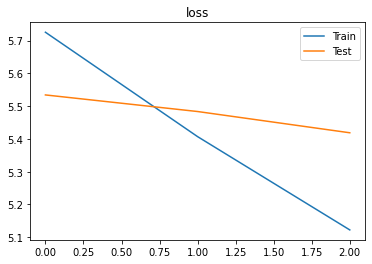

In [37]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
acc_v = history.history['val_accuracy']
loss = history.history['loss']
loss_v = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, label='Train')
plt.plot(epochs, acc_v, label='Test')
plt.legend()
plt.title('accuracy')

plt.figure()

plt.plot(epochs, loss, label='Train')
plt.plot(epochs, loss_v, label='Test')
plt.title('loss')
plt.legend()

plt.show()

In [44]:
seed_text = "And besides, they looked so frail that I could fancy myself" 
next_words = 10
  
for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    print(token_list)
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
    predicted_proba = model.predict(token_list, verbose=0)
    predicted_classes = np.argmax(predicted_proba, axis=1)

    output_word = tokenizer.index_word[predicted_classes[0]]
    seed_text += " " + output_word
    
print()
print(seed_text)

[2, 893, 36, 110, 39, 684, 10, 4, 55, 102]
[2, 893, 36, 110, 39, 684, 10, 4, 55, 102, 8]
[2, 893, 36, 110, 39, 684, 10, 4, 55, 102, 8, 1]
[2, 893, 36, 110, 39, 684, 10, 4, 55, 102, 8, 1, 3]
[2, 893, 36, 110, 39, 684, 10, 4, 55, 102, 8, 1, 3, 1]
[2, 893, 36, 110, 39, 684, 10, 4, 55, 102, 8, 1, 3, 1, 3]
[2, 893, 36, 110, 39, 684, 10, 4, 55, 102, 8, 1, 3, 1, 3, 1]
[2, 893, 36, 110, 39, 684, 10, 4, 55, 102, 8, 1, 3, 1, 3, 1, 3]
[2, 893, 36, 110, 39, 684, 10, 4, 55, 102, 8, 1, 3, 1, 3, 1, 3, 1]
[2, 893, 36, 110, 39, 684, 10, 4, 55, 102, 8, 1, 3, 1, 3, 1, 3, 1, 3]

And besides, they looked so frail that I could fancy myself was the of the of the of the of the


Очевидно, для получения лучших метрик и результатов необходимо больше эпох и времязатрат.